In [13]:
import math
import json
import random
import ast
import re
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation, CompoundLocation
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats
from collections import Counter

#### Some universal functions for reading in data from nextstrain builds

In [14]:
def readin_virus_config(virus):
    """
    Read in the config file for this virus to get the paths to alignment, metadata files, etc 
    as well as metadata about the virus such as how many subtypes, 
    and which genes are receptor-binding or polymerase
    """
    config_json = f'config/adaptive_evo_config_{virus}.json'
    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [15]:
def standardize_gene_name_reverse(virus, gene):
    """
    Find the actual gene name of the polymerase, receptor-binding, or membrane fusion protein
    """
    
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {x: configs[x]['virus_gene'] for x in genes}
    
    return gene_names[gene]


In [16]:
def standardize_gene_name(virus, gene):
    """
    Given actual name of gene, return whether it is polymerase, receptor-binding, or membrane fusion
    """
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {configs[x]['virus_gene']:x for x in genes}
    
    return gene_names[gene]

### Get data for this virus, subtype, gene and organize for the adaptation analysis

In [17]:
def subset_viruses_nextstrain_build(virus, subtype, gene, window, min_seqs, year_max, year_min):
    
    """
    Read in the alignment file for the specified virus and subtype, and extract the specified gene sequence. 
    Divide the alignment into temporal windows depending on the specified `window` argument (in years).
    Each temporal window must contain a minimum or `min_seqs` sequences, otherwise it will be excluded as missing data.
    The analysis can be limited to a certain time range by supplying `year_max` and/or `year_min`.
    """
    
    
    configs = readin_virus_config(virus)
    standard_gene = standardize_gene_name(virus, gene)
    
    #some dengue files are shared between all genotypes of the same serotype
    if virus=='dengue':
        serotype = subtype.split('_')[0]
    else:
        serotype = False
    

    #Find reference, alignment and meta files (some sub-genic regions may use files from a gene or a whole genome)
    if 'specify_location' in configs[standard_gene].keys():
        parent_gene = configs[standard_gene]['specify_location']['parent_gene']
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        #some are comma-separated, some are tab-separated
        metafile_sep = configs['metafile_sep']
    else:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=gene)
        metafile_sep = configs['metafile_sep']
        #dengue reference files are shared among serotypes
        if serotype:
            reference_file = configs['reference_file'].format(virus=virus, subtype=serotype, gene=gene)
        else:
            reference_file = configs['reference_file'].format(virus=virus, subtype=subtype, gene=gene)
    
    # if a minimum year to use is supplied in config, limit seqs to this
    if 'min_year' in configs.keys():
        year_min = int(configs['min_year'])
    
    #Find gene location, if domain is sub-genic or reference file contains multiple genes
    gene_location = False
    #If domain is sub-genic, fetch its position (within genome or parent gene) from config file
    if 'specify_location' in configs[standard_gene].keys():
        if subtype==None:
            gene_location_key = "location"
        else:
            #dengue reference files and locations are shared among serotypes
            if serotype:
                gene_location_key = "location_"+str(serotype)
            else:
                gene_location_key = "location_"+str(subtype)
            
        gene_location_list = ast.literal_eval(configs[standard_gene]['specify_location'][gene_location_key])
        #Need to deal with domains the are not contiguous
        if len(gene_location_list)==1:
            gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))
        else:
            compound_locations = []
            for location in gene_location_list:
                compound_locations.append(FeatureLocation(location[0], location[1]))
            gene_location = CompoundLocation(compound_locations)
            

    #Find gene location from reference files
    else:
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if 'gene' in feature.qualifiers.keys():
                        if feature.qualifiers['gene'][0].lower() == gene.lower():
                            gene_location = feature.location
                    if gene_location==False:
                        if 'product' in feature.qualifiers.keys():
                            if feature.qualifiers['product'][0].lower() == gene.lower():
                                gene_location = feature.location 
                    if gene_location == False:
                        if 'locus_tag' in feature.qualifiers.keys():
                            if feature.qualifiers['locus_tag'][0].lower() == gene.lower():
                                gene_location = feature.location  
                    
                        
    #Subset data based on time windows
    meta = pd.read_csv(meta_file, sep = metafile_sep)
    #drop incomplete date data
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta = meta[meta["date"].str.contains("20XX")==False]
    meta = meta[meta["date"].str.contains("36-0")==False]
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    #Remove egg- and cell-passaged strains
    meta.drop(meta[meta['strain'].str[-4:]=='-egg'].index, inplace=True)
    meta.drop(meta[meta['strain'].str[-5:]=='-cell'].index, inplace=True)
    
    #Limit meta data to only strains in alignment file
    aligned_isolates = []
    with open(alignment_file, "r") as aligned_handle:
        for isolate in SeqIO.parse(aligned_handle, "fasta"):
            aligned_isolates.append(isolate.id)
    aligned_isolates_df = pd.DataFrame(aligned_isolates, columns=['strain'])
    meta = meta.merge(aligned_isolates_df, on='strain', how='inner')
    
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            
            #sliding window
            date_window_end += 1
            date_window_start += 1 
    

    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}
    
    year_windows = []
    seqs_in_window = []
    
    #Find outgroup sequence from strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    
    alignment_time_subset = {}

    
    for years, subset_viruses in virus_time_subset.items():

        year_windows.append(years)
        seqs_in_window.append(len(subset_viruses))
        alignment_time_subset[years] = []

        #make consensus sequence at first time point
        if first_window == True:
            first_window_strains+=subset_viruses
            first_window = False
        

        with open(alignment_file, "r") as aligned_handle:
            for isolate in SeqIO.parse(aligned_handle, "fasta"):
                if isolate.id in first_window_strains:
                    if gene_location:
                        gene_record = SeqRecord(seq = gene_location.extract(isolate.seq), 
                                                id = isolate.id, description = gene)
                    else:
                        gene_record = SeqRecord(seq = isolate.seq, 
                                                id = isolate.id, description = gene)
                    first_window_sequences.append(gene_record)
                if isolate.id in subset_viruses:
                    if gene_location:
                        alignment_time_subset[years].append(gene_location.extract(isolate.seq))
                    else:
                        alignment_time_subset[years].append(isolate.seq)

    first_window_alignment = MultipleSeqAlignment(first_window_sequences)
    if virus=='rsv':
        outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).gap_consensus(ambiguous ='N')
    else:
        outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
    
    has_dup = find_duplication(outgroup_seq)
    
    #if virus has duplication, want to run Bhatt on entire alignment excluding dup, 
    #and then separately on the duplicated sequence to look at evolution occurring on top of it
    
    if has_dup:
        outgroup_seq, outgroup_seq_aa, alignment_time_subset = adjust_for_duplications(outgroup_seq, alignment_time_subset)
    else:
        outgroup_seq_aa = outgroup_seq.translate()

        
    return alignment_time_subset, outgroup_seq, year_windows 
    

In [18]:
def find_duplication(outgroup_seq):
    """
    Duplication events (or any insertions) will be signified in the outgroup sequence 
    by a series of consecutive --- placeholders. Find if there is a duplication in this 
    evolution of this virus.
    """
    has_dup = False
    outgroup_seq_str = str(outgroup_seq)
    #if there are ---s in the outgroup_seq, find where they are
    #say that insertion/duplication has to be at least 3 codons long
    if re.search("-{9,}", outgroup_seq_str):
        has_dup=True
        
        
    return has_dup

In [19]:
def adjust_for_duplications(outgroup_seq, alignment_time_subset):
    """
    Find the position and length of the duplication.
    Remove the duplicated region from the outgroup sequence and the every sequence in the alignment.
    Evolution on the duplicated region will be considered separately because the outgroup consensus 
    for this region needs to done from the first timepoint where there are sequences with the duplication
    """

    outgroup_seq_str = str(outgroup_seq)
    #find where the duplication is by locating ---s in the outgroup_seq
    if re.search("-{9,}", outgroup_seq_str):
        dup_start, dup_end = [(x.start(),x.end()) for x in re.finditer(r'-{9,}', outgroup_seq_str)][0]


    outgroup_wo_dup = Seq(outgroup_seq_str[:dup_start]+outgroup_seq_str[dup_end:])
    outgroup_wo_dup_aa = outgroup_wo_dup.translate()

    # remove the duplicated portion from the main alignment
    alignment_time_subset_wo_dup = {}
    for dates, strain_seqs in alignment_time_subset.items():
        strain_seqs_wo_dup = [Seq(str(x)[:dup_start]+str(x)[dup_end:]) for x in strain_seqs]
        alignment_time_subset_wo_dup[dates] = strain_seqs_wo_dup
    
        
    
    return outgroup_wo_dup, outgroup_wo_dup_aa, alignment_time_subset_wo_dup



In [20]:
def split_alignment_outgroup_into_codons(virus, subtype, gene, window, min_seqs, year_max, year_min):
    """
    Divide the outgroup sequence and each sequence in the alignment into a list of codons.
    The outgroup sequence will be returned as a list of lists, ex: [['ATG'],['GAA'],['ATT']]
    The alignment will be returned as a dictionary, where the key is the time window and the 
    value is the alignment of sequences sampled during that time window. 
    The alignment will be given as a list of lists (each element is the sequence of an isolate, 
    given as a list of its codons) 
    """
    
    (alignment_time_subset, 
     outgroup_seq, year_windows) = subset_viruses_nextstrain_build(virus, subtype, gene, 
                                                                   window, min_seqs, year_max, year_min)
    
    
    #make list of the codon sequence at each position in the gene
    if len(outgroup_seq) %3 !=0:
        print(f'{virus} {gene} not divisible by 3, check config files')
    outgroup_codons = [[str(outgroup_seq[i:i+3])] for i in range(0, len(outgroup_seq), 3)] 
    
    #alignment_time_subset is a dictionary with key as year range 
    #and value as list of sequences sampled in that time range
    #convert the sequence of each sample to a list of codons
    aligned_codons_in_window = {}
    for k,v in alignment_time_subset.items():
        #initiate list to store all samples from this time window
        all_isolates = []
        for isolate in v:
            isolate_codons = [str(isolate[i:i+3]) for i in range(0, len(isolate), 3)] 
            all_isolates.append(isolate_codons)
            
        aligned_codons_in_window[k] = all_isolates
 
    return aligned_codons_in_window, outgroup_codons, year_windows


In [21]:
def save_organized_data(virus, subtype, gene, window, min_seqs, year_max, year_min):
    """
    Save the alignment and outgroup data for a given virus, subtype, gene, window, min_seqs, year_min, year_max combo.
    """
    (aligned_codons_in_window, outgroup_codons, 
     year_windows) = split_alignment_outgroup_into_codons(virus, subtype, gene, window, 
                                                          min_seqs, year_max, year_min)
    
    save_json = {'year_windows':year_windows, 'outgroup_codons':outgroup_codons, 
                 'aligned_codons_in_window': aligned_codons_in_window}
    
    
    filepath = 'adaptation_results/intermediates/'
    
    save_filename = f'{filepath}input_data_{virus}_{subtype}_{gene}_{window}_{min_seqs}_{year_min}_{year_max}.json'
        
    with open(save_filename, 'w') as outfile:
        json.dump(save_json, outfile)

In [22]:
def readin_data(saved_data_name):
    with open(saved_data_name) as json_handle:
        json_dict = json.load(json_handle)
        (aligned_codons_in_window, outgroup_codons, year_windows) = (json_dict['aligned_codons_in_window'], 
                                                                     json_dict['outgroup_codons'], 
                                                                     json_dict['year_windows'])
    return aligned_codons_in_window, outgroup_codons, year_windows

In [15]:
def get_alignment_outgroup_data(virus, subtype, gene, window, min_seqs, year_max, year_min):
    """
    If the alignment and outgroup data has already been organized for this 
    virus, subtype, gene, window, min_seqs, year_min, year_max combo, then read in the data. 
    Otherwise, calculate it and save it. Return aligned_codons_in_window, outgroup_codons, year_windows
    """
    
    filepath = 'adaptation_results/intermediates/'
    
    saved_data_name = f'{filepath}input_data_{virus}_{subtype}_{gene}_{window}_{min_seqs}_{year_min}_{year_max}.json'
    
    #prepare data and save it if this has not already been done
    if not path.exists(saved_data_name):
        save_organized_data(virus, subtype, gene, window, min_seqs, year_max, year_min)
    
    #read in the prepared alignment and outgroup data
    (aligned_codons_in_window, outgroup_codons, year_windows) = readin_data(saved_data_name)
    

    return aligned_codons_in_window, outgroup_codons, year_windows

### Make bootstrapped dataset (sampled with replacement) for outgroup and alignment codons

In [16]:
def bootstrap_alignment(bootstrap_codon_order, isolates):
    """
    For each time point, create a bootstrapped alignment of the same size as the empirical alignment.
    The randomized codon order (bootstrap_codon_order) is chosen in `bootstrap_outgroup`.
    """
    
    bootstrap_aligned_codons = []
    for isolate_codons in isolates:
        bootstrap_isolate = [isolate_codons[x] for x in bootstrap_codon_order]
        bootstrap_aligned_codons.append(bootstrap_isolate)
    
    return bootstrap_aligned_codons

In [17]:
def bootstrap_outgroup(outgroup_codons):
    """
    Sample the empirical outgroup codons with replacement
    """

    bootstrap_codon_order = random.choices(range(len(outgroup_codons)), k=len(outgroup_codons))
    bootstrap_outgroup_codons = [outgroup_codons[x] for x in bootstrap_codon_order]
    
    return bootstrap_outgroup_codons, bootstrap_codon_order

In [18]:
def make_bootstrap_dataset(outgroup_codons, aligned_codons_in_window):
    """
    Make a bootstrap outgroup sequence and alignment, with the same 
    number of samples per time window as the empirical data 
    """
            
    bootstrap_outgroup_codons, bootstrap_codon_order = bootstrap_outgroup(outgroup_codons)

    
    bootstrap_alignment_codons = {}
    for years, aligned_isolates in aligned_codons_in_window.items():
        bootstrap_aligned_codons = bootstrap_alignment(bootstrap_codon_order, aligned_isolates)
        bootstrap_alignment_codons[years] = bootstrap_aligned_codons
    
        
    return bootstrap_outgroup_codons, bootstrap_alignment_codons

### Within each time window, find the number of polymorphisms relative to the outgroup, and the frequency of those polymorphisms

In [19]:
def frequency_binning(x, midfreq_high, midfreq_low):
    """
    Given a polymorphism frequency, return a frequency bin (fixed, high-freq, mid-freq, or low-freq)
    """

    #nan frequencies are when there is no sequence coverage at the given position
    if math.isnan(x):
        f_bin = float('nan')
    else:
        if x == 1.0:
            f_bin = 'f'
        elif x>=midfreq_high:
            f_bin = 'h'
        elif x<midfreq_high and x>=midfreq_low:
            f_bin = 'm'
        elif x<midfreq_low:
            f_bin='l'

    return f_bin

In [20]:
def determine_polymorphic_frequency(outgroup_codon, alignment_codons, midfreq_high, midfreq_low):
    """
    Find the percent of ingroup bases that are polymorphic at each position.
    Then convert this to a frequency bin, depending on the midfreq_high and midfreq_low settings
    See Bhatt et al, 2011.
    """
    #for each of the 3nts in the codon,
    #count the number of polymorphisms
    polymorphic_count = [0,0,0]
    
    
    for i in range(3):
        outgroup_nt = outgroup_codon[i]
        ingroup_nts = [alignment_codons[x][i] for x in range(len(alignment_codons))]
        num_polymorphisms = len([x for x in ingroup_nts if x!=outgroup_nt])
        polymorphic_count[i] = num_polymorphisms
    
    polymorphic_frequency = [x/len(alignment_codons) for x in polymorphic_count]
    
    frequency_bins = [frequency_binning(x, midfreq_high, midfreq_low) for x in polymorphic_frequency]

    
    return frequency_bins

In [21]:
def determine_site_type(outgroup, ingroup):
    """
    Determine site type in order to assign a fixation and polymorphism score
    """

    ingroup_bases = set(ingroup)

    
    if len(ingroup_bases) == 0:
        site_type = None
    
    elif len(ingroup_bases) != 0:
        #all ingroup bases are identical
        if len(ingroup_bases) == 1:
            if outgroup in ingroup_bases:
                site_type = 1
            elif outgroup not in ingroup_bases:
                site_type = 2

        #2 different bases in ingroup
        elif len(ingroup_bases) == 2:
            if outgroup in ingroup_bases:
                site_type = 3
            elif outgroup not in ingroup_bases:
                site_type = 4

        #3 different bases in ingroup
        elif len(ingroup_bases) == 3:
            if outgroup in ingroup_bases:
                site_type = 5
            elif outgroup not in ingroup_bases:
                site_type = 6

        #4 different bases in ingroup
        elif len(ingroup_bases) == 4:
            site_type = 7
    
    
    return site_type

In [22]:
def fixation_polymorphism_score(outgroup, ingroup):
    """
    Assign a fixation or polymorphism score (see Bhatt et al)
    """
    site_type = determine_site_type(outgroup, ingroup)

    
    if site_type == None:
        Fi = float('nan')
        Pi = float('nan')
    if site_type == 1:
        Fi = 0
        Pi = 0
    elif site_type == 2:
        Fi = 1
        Pi = 0
    elif site_type in [3,5,7]:
        Fi = 0
        Pi = 1
    elif site_type == 4:
        Fi = 0.5
        Pi = 0.5
    elif site_type == 6:
        Fi = (1/3)
        Pi = (2/3)
    
    return Fi, Pi

In [23]:
def determine_fi_pi(outgroup_codon, alignment_codons):
    """
    Determine the fixation and polymorphism scores at each nucleotide position in codon.
    See Bhatt et al, 2010.
    """
    
    #for each of the 3nts in the codon,
    #store the Fi and Pi score
    Fi_score = [0,0,0]
    Pi_score = [0,0,0]
    
    #go through each nt position in the codon to determine polymorphisms relative to the outgroup
    for i in range(3):
        outgroup_nt = outgroup_codon[i]
        ingroup_nts = [alignment_codons[x][i] for x in range(len(alignment_codons))]
        #determine fixation and polymorphism by how many different bases appear in the ingroup
        Fi, Pi = fixation_polymorphism_score(outgroup_nt, ingroup_nts)
        Fi_score[i] = Fi
        Pi_score[i] = Pi

    return Fi_score, Pi_score

In [24]:
def determine_replacement_silent(outgroup_codon, alignment_codons):
    """
    Determine whether a nucleotdie mutation is silent or replacement.
    Given the outgroup codon (say AAT), and all codons at this position of the alignment (say AAT, ATT, ATT, ATG),
    find the replacement score as the number of ingroup bases that, 
    if substituted into the outgroup sequence would change the amino acid.
    This function takes in codon sequences 
    and will return the replacement score at each position of the codon (returns a list of 3 replacement scores).
    See Bhatt et al, 2010.
    """
    #for each of the 3nts in the codon,
    #store the number of ingroup bases that, when subsituted into the outgroup, would change the amino acid
    replacement_counts = [0,0,0]

    #outgroup amino acid
    outgroup_aa = Seq(outgroup_codon).translate()
    
    #go through each nt position in the codon to determine mutations relative to the outgroup
    for i in range(3):
        nt_ingroup = [alignment_codons[x][i] for x in range(len(alignment_codons))]
        for nt in nt_ingroup:
            mutated_outgroup_codon = MutableSeq(outgroup_codon)
            mutated_outgroup_codon[i] = nt
            mutated_outgroup_aa = Seq(mutated_outgroup_codon).translate()
            if outgroup_aa != mutated_outgroup_aa:
                replacement_counts[i]+=1

    
    replacement_scores = [x/len(alignment_codons) for x in replacement_counts]
    
    return replacement_scores

In [43]:
def walk_through_codons(aligned_isolates, outgroup_codons, midfreq_high, midfreq_low):
    """
    For a single time window, find codons where there is a mutation between the aligned sequences and the outgroup.
    Calculate replacement and silent scores (see Bhatt et al, 2010), 
    polymorphic and fixation scores (see Bhatt et al, 2010), and frequency bins (see Bhatt et al, 2011)
    """
    #length of gene in codons
    num_codons = len(outgroup_codons)
    
    #initiate array with one position for each nucleotide in gene to keep track of replacement scores
    #and fixation, polymorphism scores
    replacement_scores_this_window = [0 for x in range(num_codons*3)] 
    #default to 0, because, in the absense of mutations to the codon, both Fi and Pi will be 0
    fixation_scores_this_window = [0 for x in range(num_codons*3)] 
    polymorphism_scores_this_window = [0 for x in range(num_codons*3)]   
    #also keep track of frequency bins at each site
    #as default, sites are "low", which could create confusion between sites with 0 mutations 
    #and those with mutations actually present at low frequencies, like 0.05. 
    #However, this is ok, because when calculating the Bhatt estimators, the Fi and Pi score will 
    #be 0 for sites with no mutations, so the estimators will not get contributions from sites with no mutations
    frequency_bins_this_window = ['l' for x in range(num_codons*3)]
    
    #keep track of where mutations have fixed
    #dict of fixations has codon position as key and codon sequence as values
    fixations_during_this_window = {'syn':{}, 'nonsyn':{}}
    
    
    #walk through each codon in the gene
    for i in range(num_codons):
    
        outgroup = outgroup_codons[i][-1]
        #skip ambiguous sequencing
        if all(char in ['A','C','G','T'] for char in outgroup):
            alignment_codons = [aligned_isolates[x][i] for x in range(len(aligned_isolates))]

            #skip ambiguous sequencing
            alignment_codons = [x for x in alignment_codons if all(char in ['A','C','G','T'] for char in x)]

            #number of unabiguous codons at this position
            total_alignment_size = len(alignment_codons)
            #number of codons with mutations at this position
            #compare to the outgroup sequence, which is either the original outgroup codon seq 
            #or the most recent fixation at this position, if there has been one
            mutations = [x for x in alignment_codons if x!=outgroup]
            total_mutations = len(mutations)


            #if there are mutations, find whether they are silent or replacement, and update the replacement score
            #replacement scores are determined for each nucleotide position
            #also find the fixation and polymorphism scores, also determined at each nt pos
            if total_mutations > 0:
                
                #determine replacement scores within this codon
                replacement_scores_within_codon = determine_replacement_silent(outgroup, alignment_codons)
                #add these replacement scores to the proper nucelotide positions
                codon_start = i*3
                replacement_scores_this_window[codon_start-1:codon_start+2] = replacement_scores_within_codon
                
                #find fixation and polymorphism scores within this codon
                Fi_score_within_codon, Pi_score_within_codon = determine_fi_pi(outgroup, alignment_codons)
                fixation_scores_this_window[codon_start-1:codon_start+2] = Fi_score_within_codon
                polymorphism_scores_this_window[codon_start-1:codon_start+2] = Pi_score_within_codon
                
                #find the polymorphic frequency at each nt position in the codon
                freq_bins_within_codon = determine_polymorphic_frequency(outgroup, alignment_codons, midfreq_high, midfreq_low)
                frequency_bins_this_window[codon_start-1:codon_start+2] = freq_bins_within_codon
                
                #if a mutation fixed in this codon, want to update the outgroup sequence
                if 'f' in freq_bins_within_codon:
                    #apply the fixed nts to the outgroup codon
                    fixed_codon = ''.join([alignment_codons[0][i] if freq_bins_within_codon[i]=='f' else outgroup[i] for i in range(3)])
                    if Seq(fixed_codon).translate() == Seq(outgroup).translate():
                        fixations_during_this_window['syn'][i] = fixed_codon
                    else:
                        fixations_during_this_window['nonsyn'][i] = fixed_codon

    
    #Si = 1-Ri
    silent_scores_this_window = [1-x for x in replacement_scores_this_window]

                
    return (replacement_scores_this_window, silent_scores_this_window, 
            fixation_scores_this_window, polymorphism_scores_this_window, 
            frequency_bins_this_window, fixations_during_this_window)
    

In [44]:
def calc_m_ratio(virus, subtype, gene, min_seqs, midfreq_high, midfreq_low, year_max, year_min, bootstrap):
    """
    M = rm/sm
    M not expected to vary through time provided that long-term effective population sizes remain sufficiently large
    For each gene, calculate M by combining site count among time points (use window='all'). 
    If the gene is the receptor-binding gene or 'ha_protein', use a non-antigenic gene, 
    with a sufficient number of neutrally-evolving sites, to calculate M.
    """
    configs = readin_virus_config(virus)
    nonantigenic_gene = configs['nonantigenic_gene']

    
    #if the gene is 'ha_protein' or 'receptor_binding', use a non-antigenic gene 
    #with a sufficient number of neutrally-evolving site to calculate M
    if standardize_gene_name(virus, gene) =='ha_protein' or standardize_gene_name(virus, gene) =='receptor_binding':
        (aligned_codons_in_window, outgroup_codons, 
         year_windows) = get_alignment_outgroup_data(virus, subtype, nonantigenic_gene, 
                                                     'all', min_seqs, year_max, year_min)
    #otherwise, calculate M from this gene    
    else:
        (aligned_codons_in_window, outgroup_codons, 
         year_windows) = get_alignment_outgroup_data(virus, subtype, gene, 
                                                     'all', min_seqs, year_max, year_min)
        

        
    #if calculating bootstrapped M, need to first get the bootstrapped data
    #then calculate the Ri, Si, Fi, Pi, freq_bins based off bootstrapped data
    if bootstrap:
        (bootstrap_outgroup_codons, bootstrap_alignment_codons) = make_bootstrap_dataset(outgroup_codons, 
                                                                                             aligned_codons_in_window)
        
        
        (Ri, Si, Fi, Pi, frequency_bins, fixed_codons) = walk_through_codons(bootstrap_alignment_codons[year_windows[0]], 
                                                               bootstrap_outgroup_codons, 
                                                           midfreq_high, midfreq_low)

    #otherwise, calc Ri, Si, Fi, Pi, freq_bins from the empirical data
    else:
        aligned_isolates = aligned_codons_in_window[year_windows[0]]
        (Ri, Si, Fi, Pi, frequency_bins, fixed_codons) = walk_through_codons(aligned_isolates, outgroup_codons, 
                                                           midfreq_high, midfreq_low)
        
    
    #length of the gene the m_ratio is being calculated for
    length_nt = len(outgroup_codons)*3

    #calculate sm and rm (mid-frequency mutations assumed to be neutrally-evolving)
    sm = 0
    rm = 0
    
    #updating outgroup doesn't matter for m_ratio because the window is 'all' years
    for i in range(length_nt):
        freq_bin = frequency_bins[i]
        if freq_bin == 'm':
            sm+= (Pi[i]*Si[i])
            rm+= (Pi[i]*Ri[i])

    #give false, small number if sm=0 to avoid divide by 0 error
    if sm ==0:
        sm = 0.00000000000000001
    m_ratio = rm/sm
    
    return m_ratio

In [27]:
def calc_bhatt_estimators(aligned_codons_in_window, outgroup_codons, year_windows, m_ratio, 
                          midfreq_high, midfreq_low, bootstrap, update_outgroup):
    """
    Use Fi, Pi, Ri, Si and frequency bins to calculate the Bhatt estimators 
    sf, rf, sh, rh, sm, rm, sl, and rl for each time window. 
    Calculate a from these estimators.
    """

    length_nt = len(outgroup_codons)*3
    
    #keep track of adaptive subtitutions in each time window
    adaptive_substitutions = []
    #initiate list to store the window midpoints
    window_midpoints = []
    
    #initiate fixed_codons dict, to be added to as mutations fix
    fixed_codons_all_time = {'syn':0, 'nonsyn':0}

    
    #for each year window, find mutations in the aligned sequences relative to the outgroup
    for year_window in year_windows:
        #find the window midpoint (this will be the label for the plot)
        window_start = int(year_window[0:4])
        window_end = int(year_window[-4:])
        window_midpoints.append((window_start + window_end)/2)
        
        #if counting repeat mutations at same codon, need to increase the count for sites that have already fixed
        #fixed sites were saved in 'fixed_codons_all_time' during the last year_window
        if update_outgroup:
            increase_syn_fixations = fixed_codons_all_time['syn']
            increase_nonsyn_fixations = fixed_codons_all_time['nonsyn']
            
        
        #list of isolates in this time window, each given as a list of codon sequences
        aligned_isolates = aligned_codons_in_window[year_window]
        (Ri, Si, Fi, Pi, frequency_bins, fixed_codons) = walk_through_codons(aligned_isolates, outgroup_codons, 
                                                               midfreq_high, midfreq_low)
        #add codons that were fixed in the last window
        if update_outgroup:
            fixed_codons_all_time['syn']+=len(fixed_codons['syn'])
            fixed_codons_all_time['nonsyn']+=len(fixed_codons['nonsyn'])
            

            
        
        #bhatt estimators are the sum over all sites in the nucleotide alignment
        sf = 0
        rf = 0
        sh = 0
        rh = 0
        sm = 0
        rm = 0
        sl = 0
        rl = 0
        
        
        for i in range(length_nt):
            freq_bin = frequency_bins[i]
            if freq_bin == 'f':
                sf+= (Fi[i]*Si[i])
                rf+= (Fi[i]*Ri[i])
            elif freq_bin == 'h':
                sh+= (Pi[i]*Si[i])
                rh+= (Pi[i]*Ri[i])
            elif freq_bin == 'm':
                sm+= (Pi[i]*Si[i])
                rm+= (Pi[i]*Ri[i])
            elif freq_bin == 'l':
                sl+= (Pi[i]*Si[i])
                rl+= (Pi[i]*Ri[i]) 
                
        #if counting repeat mutations at same codon, need to add fixations that have already occurred
        #fully fixed mutations will add 1 to sf if silent, or 1 to rf if replacement because sf=Fi*Si=1 or rf=Fi*Ri=1
        if update_outgroup:
            sf+=increase_syn_fixations
            rf+=increase_nonsyn_fixations
        
        #Calculate equation 1: number of nonneutral sites
        al = rl - sl*m_ratio
        ah = rh - sh*m_ratio
        af = rf - sf*m_ratio
        
        #set negative a values to zero
        if al < 0:
            al = 0
        if ah < 0:
            ah = 0
        if af < 0:
            af = 0

        
        #Calculate the number and proportion of all fixed or high-freq sites that have undergone adaptive change
        number_adaptive_substitutions = af + ah
        adaptive_substitutions.append(number_adaptive_substitutions)
        
        if update_outgroup:
            #Update the outgroup sequence for the next time window
            for pos, seq in fixed_codons['syn'].items():
                outgroup_codons[pos].append(seq)
            for pos, seq in fixed_codons['nonsyn'].items():
                outgroup_codons[pos].append(seq)


    adaptive_substitutions_per_codon = [x/len(outgroup_codons) for x in adaptive_substitutions]
    
    if len(window_midpoints)!=0:
        rate_of_adaptation, intercept, r_value, p_value, std_err = stats.linregress(window_midpoints, adaptive_substitutions_per_codon)
    else:
        rate_of_adaptation = 0
    
    
    return window_midpoints, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation
        
    

In [45]:
def calc_bhatt_a(virus, subtype, gene, window, min_seqs, year_max, year_min,
                 midfreq_high, midfreq_low, bootstrap, update_outgroup):
    
    """
    Bhatt a (adaptive substitutions), and rate of adaptation are calculated in `calc_bhatt_estimators`. 
    This is wrapper function to run `calc_bhatt_estimators` on both empirical data and bootstrapped data (if bootstrap=True)  
    """
    
    #Get virus subset
    (aligned_codons_in_window, outgroup_codons, 
     year_windows) = get_alignment_outgroup_data(virus, subtype, gene, 
                                                 window, min_seqs, year_max, year_min)
    
    
    m_ratio = calc_m_ratio(virus, subtype, gene, min_seqs, midfreq_high, midfreq_low, year_max, year_min, False)

    
    (window_midpoints, adaptive_substitutions, adaptive_substitutions_per_codon, 
     rate_of_adaptation) = calc_bhatt_estimators(aligned_codons_in_window, outgroup_codons, 
                                                 year_windows, m_ratio, midfreq_high, midfreq_low, 
                                                 bootstrap, update_outgroup)
    
    
    

    n_bootstraps = 100
    bootstrap_count = 0
    
    bootstrap_adaptive_substitutions = []
    bootstrap_adaptive_substitutions_per_codon = []
    bootstrap_rates_of_adaptation = []
    if bootstrap:
        while bootstrap_count < n_bootstraps:
            if bootstrap_count%10==0:
                print(f'{virus} {gene}: {bootstrap_count} bootstraps done')
            bootstrap_count+=1
            #Get bootstrapped ancestral seq and alignment
            (bootstrap_outgroup_codons, bootstrap_alignment_codons) = make_bootstrap_dataset(outgroup_codons, 
                                                                                            aligned_codons_in_window)
            #calc bootstrapped m_ratio
            bootstrap_m_ratio = calc_m_ratio(virus, subtype, gene, min_seqs, 
                                             midfreq_high, midfreq_low, year_max, year_min, True)

            #calculate bootstrapped rate of adaptation
            (window_midpoints, bs_adaptive_substitutions, 
             bs_adaptive_substitutions_per_codon, 
             bs_rate_of_adaptation) = calc_bhatt_estimators(bootstrap_alignment_codons, bootstrap_outgroup_codons, 
                                                                   year_windows, bootstrap_m_ratio, midfreq_high, midfreq_low, 
                                                                   bootstrap, update_outgroup)


            #add these bootstrap values to list
            bootstrap_adaptive_substitutions.append(bs_adaptive_substitutions)
            bootstrap_adaptive_substitutions_per_codon.append(bs_adaptive_substitutions_per_codon)
            bootstrap_rates_of_adaptation.append(bs_rate_of_adaptation)
    
    if bootstrap:
        return window_midpoints, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation, bootstrap_adaptive_substitutions, bootstrap_adaptive_substitutions_per_codon, bootstrap_rates_of_adaptation

    else:
        return window_midpoints, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation


In [29]:
def run_adaptation_analysis(virus, subtype, gene, window, min_seqs, year_max, year_min,
                             midfreq_high, midfreq_low, bootstrap, update_outgroup):
    
    data_to_plot = []
    
    if subtype==None:
        virus_subtype = virus
        virus_and_subtype = virus
    else:
        virus_subtype = subtype
        virus_and_subtype = virus+'_'+subtype
    
    if bootstrap:
        save_json_name = f'adaptation_results/results/{virus_and_subtype}_{gene}_{window}_{min_seqs}_adaptation_bootstrapped.json'
        if path.exists(save_json_name):
            with open(save_json_name) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])

        else:

            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation, bootstrap_adaptive_substitutions, 
             bootstrap_adaptive_substitutions_per_codon, 
             bootstrap_rate_of_adaptation) = calc_bhatt_a(virus, subtype, gene, window, min_seqs, year_max, year_min,
                                                            midfreq_high, midfreq_low, bootstrap, update_outgroup)

            save_json = {'virus': virus, 'subtype':subtype, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                         'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                         'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                         'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 'rate_of_adaptation': rate_of_adaptation,
                         'bootstrap_adaptive_substitutions': bootstrap_adaptive_substitutions, 
                         'bootstrap_adaptive_substitutions_per_codon': bootstrap_adaptive_substitutions_per_codon, 
                         'bootstrap_rate_of_adaptation':bootstrap_rate_of_adaptation}
            with open(save_json_name, 'w') as outfile:
                json.dump(save_json, outfile)

        slope_sci = rate_of_adaptation * (10**3)
        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)

        data_to_plot.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                             'gene': standardize_gene_name(virus, gene),
                             'adaptive_subs_per_codon_per_year': slope_sci, 
                             'lower_95ci': lower_95ci, 'upper_95ci': upper_95ci, 
                             'ci': [lower_95ci, upper_95ci]})




    else:
        save_json_name = f'adaptation_results/results/{virus_and_subtype}_{gene}_{window}_{min_seqs}_adaptation.json'
        if path.exists(save_json_name):
            with open(save_json_name) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation) = (json_dict['window_midpoint'], 
                                        json_dict['adaptive_substitutions'], 
                                        json_dict['adaptive_substitutions_per_codon'], 
                                        json_dict['rate_of_adaptation'])


        else:
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation) = calc_bhatt_a(virus, subtype, gene, window, min_seqs, year_max, year_min,
                                                 midfreq_high, midfreq_low, bootstrap, update_outgroup)
            

            save_json = {'virus': virus, 'subtype':subtype, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                         'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                         'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                         'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 
                         'rate_of_adaptation': rate_of_adaptation}
            with open(save_json_name, 'w') as outfile:
                json.dump(save_json, outfile)

        slope_sci = rate_of_adaptation * (10**3)
        data_to_plot.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype':virus_and_subtype, 
                             'gene': standardize_gene_name(virus, gene),
                             'adaptive_subs_per_codon_per_year': slope_sci})
    

    return data_to_plot

In [48]:
#calculated as slope of adaptive subs per codon
def compare_viruses_adaptive_rate(viruses, standard_genes=['polymerase', 'receptor_binding'], 
                                  exclude=None,
                                  window=5, min_seqs=3, bootstrap=False, update_outgroup=True,
                                  midfreq_high=0.75, midfreq_low=0.15, year_max=None, year_min=None, filename=None):
    

    
    data_to_plot = []
    color_map = {}
    virus_families = {}
    
    virus_names_legible = {}
    
    for virus in viruses:
        
        configs = readin_virus_config(virus)
        standard_genes_to_plot = [x for x in standard_genes if configs[x]['virus_gene']!='None']
        genes = [standardize_gene_name_reverse(virus, x) for x in standard_genes_to_plot]
        
        if configs['subtype']=='True':
            subtypes = configs['subtypes']
            for subtype in subtypes:
                virus_and_sub = virus+'_'+subtype
                color_map[virus_and_sub] = configs['color'][subtype]
                virus_families[virus_and_sub] = configs['virus_family']
                virus_names_legible[virus_and_sub] = configs['legible_name'][subtype]
                
                for gene in genes:
                    if gene!="None":
                        data_to_plot+=run_adaptation_analysis(virus, subtype, gene, window, min_seqs, year_max, year_min,
                                                             midfreq_high, midfreq_low, bootstrap, update_outgroup)

        else:
            subtype=None
            color_map[virus] = configs['color']
            virus_families[virus] = configs['virus_family']
            virus_names_legible[virus] = configs['legible_name']
            for gene in genes:
                if gene!="None":
                    data_to_plot+=run_adaptation_analysis(virus, subtype, gene, window, min_seqs, year_max, year_min,
                                                             midfreq_high, midfreq_low, bootstrap, update_outgroup)

    
    df_to_plot = pd.DataFrame(data_to_plot)
    
    if exclude!=None:
        for e in exclude:
            df_to_plot = df_to_plot[df_to_plot['virus_and_subtype']!=e]
            virus_families = {k:v for k,v in virus_families.items() if k not in exclude}
    
    viruses_and_subtypes = list(df_to_plot['virus_and_subtype'].unique())

    
    #make subplot heights relative to max y-axis value
    gene_yranges = []
    for gene in standard_genes:
        if bootstrap:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['upper_95ci'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['lower_95ci'].min()
        else:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['adaptive_subs_per_codon_per_year'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['adaptive_subs_per_codon_per_year'].min()
        yrange = max_rate_for_gene - min_rate_for_gene
        gene_yranges.append(yrange)
        
    height_ratios= [x/max(gene_yranges) for x in gene_yranges]
        
    fig, axs = plt.subplots(len(standard_genes), 1, figsize=(len(viruses_and_subtypes)*0.5,10), 
                            gridspec_kw={'height_ratios':height_ratios}, sharex=True)        
    
    #legible gene labels
    genes_legible = {'polymerase': 'Polymerase', 'receptor_binding': 'Receptor Binding', 
                        'membrane_fusion': 'Membrane Fusion'}
    
    #make x-coordinates for each virus-subtype
    #cannot figure out how to do custom error bars in seaborn, which is why I'm doing it this way
    x_coords = {}
    all_x_ticks = []
    last_coord = 0.0
    spacing = {**{x:0.2 for x in range(1,8)}, **{y:0.3 for y in range(8,12)}, 
               **{z:0.5 for z in range(12,20)}, **{a:0.8 for a in range(20,35)}, 
               **{b:1.0 for b in range(35,50)}}
    #squish spacing between dengue genotypes of same serotype
    squished_spacing = {**{x:0.1 for x in range(1,8)}, **{y:0.1 for y in range(8,12)}, 
                        **{z:0.2 for z in range(12,20)}, **{a:0.28 for a in range(20,35)}, 
                        **{b:0.35 for b in range(35,50)}}
    height_all_subplots = 0.6
    
    dengue_serotypes_seen = []
    for v in viruses_and_subtypes:
        if 'dengue' in v:
            if v.split('_')[1] in dengue_serotypes_seen:
                last_coord+=squished_spacing[len(viruses_and_subtypes)]
                x_coords[v] = last_coord
                all_x_ticks.append(last_coord)
            else:
                dengue_serotypes_seen.append(v.split('_')[1])
                last_coord+=spacing[len(viruses_and_subtypes)]
                x_coords[v] = last_coord
                all_x_ticks.append(last_coord)
        else:
            last_coord+=spacing[len(viruses_and_subtypes)]
            x_coords[v] = last_coord
            all_x_ticks.append(last_coord)

    for i in range(len(standard_genes)):
        gene = standard_genes[i]
        
        if bootstrap:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['upper_95ci'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['lower_95ci'].min()
        else:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['adaptive_subs_per_codon_per_year'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['adaptive_subs_per_codon_per_year'].min()
        yaxis_max= max_rate_for_gene+0.1
        yaxis_min= min_rate_for_gene-0.1
        
        axs[i].set_ylim([yaxis_min, yaxis_max])
        height_all_subplots+=(yaxis_max-yaxis_min)
        
        for virus_subtype in viruses_and_subtypes:
            #allow some viruses to not have some of the genes (aka membrane fusion)
            if len(df_to_plot[(df_to_plot['gene']==gene)&(df_to_plot['virus_and_subtype']==virus_subtype)])!=0:
                x = x_coords[virus_subtype]
                df_row = df_to_plot[(df_to_plot['gene']==gene)&(df_to_plot['virus_and_subtype']==virus_subtype)]
                y = float(df_row['adaptive_subs_per_codon_per_year'])
                if bootstrap:
                    err_lower = float(df_row['lower_95ci'])
                    err_upper = float(df_row['upper_95ci'])
                    axs[i].vlines(x, err_lower, err_upper, color_map[virus_subtype])
                axs[i].plot(x, y, 'o', ms=12, color=color_map[virus_subtype])
        
        axs[i].tick_params(axis='x',size=0)
        axs[i].set_xticklabels([])
        axs[i].text(0.0, yaxis_max+0.2, genes_legible[gene], size=16, color='#878787')
        
        if i == 1:
            axs[i].text(-len(viruses_and_subtypes)*0.1, height_all_subplots*0.5, r'Adaptive Muts per Codon per Year $(x 10^{-3})$', 
                        size=16, rotation='vertical', va='center')
            
    plt.rcParams['ytick.labelsize']=14
    plt.subplots_adjust(hspace=0.3)

    x_coords = {virus_names_legible[k]:v for k,v in x_coords.items()}
    
    num_family_members = dict(Counter(list(virus_families.values())))
    used_families = []
    #manual offset for family labels
    family_text_offset = {'paramyxovirus':0.2, 'Paramyxovirus, Pneumovirus': 0.2, 'orthomyxovirus':0.8,'coronavirus':-0.2,
                          'pneumovirus':-0.6,'flavivirus':1.2, 'reovirus':-0.8, 
                          'picornavirus':0.4, 'caliciviridae':-1.0, 'parvovirus':-0.6, 
                          'adenovirus': -0.4, 'hepadnavirus': -0.4}

    virus_families = {virus_names_legible[k]:v for k,v in virus_families.items()}
        
    for virus_subtype in viruses_and_subtypes:
        virus_name = virus_names_legible[virus_subtype]
        x = x_coords[virus_name]
        if virus_families[virus_name] not in used_families:
            virus_family = virus_families[virus_name]
            if 'Dengue' in virus_name:
                bar_length = spacing[len(viruses_and_subtypes)]*4 + (squished_spacing[len(viruses_and_subtypes)]*(num_family_members[virus_family]-4))
            else:
                bar_length = spacing[len(viruses_and_subtypes)]*num_family_members[virus_family]
            offset = spacing[len(viruses_and_subtypes)]
            axs[-1].plot([x-offset+0.1, x+bar_length-offset-0.1], [-height_all_subplots*0.33, -height_all_subplots*0.33], 
                         color=color_map[virus_subtype], clip_on=False, lw=3.0)
            axs[-1].text(x+offset+family_text_offset[virus_family], (-height_all_subplots*0.33-0.2),
                                       virus_family, color=color_map[virus_subtype], rotation=15, ha='right', rotation_mode='anchor')
            used_families.append(virus_family)
            
    #label viruses on bottom plot
    #want to condense names for some viruses to make x-axis less busy
    subviruses_to_group = [{'Dengue 1':['Dengue 1-I', 'Dengue 1-III', 'Dengue 1-IV', 'Dengue 1-V']}, 
                           {'Dengue 2':['Dengue 2-AA', 'Dengue 2-AI', 'Dengue 2-C']}, 
                           {'Dengue 3':['Dengue 3-II', 'Dengue 3-III']}, 
                           {'Dengue 4': ['Dengue 4-I', 'Dengue 4-II']}]
    
    if 'dengue' in viruses:
        for virus_grouping in subviruses_to_group:
            for k, v in virus_grouping.items():
                grouping_start_coord = min([x_coords[x] for x in v])
                grouping_end_coord = max([x_coords[x] for x in v])
                grouping_mid_label_coord = (grouping_start_coord+grouping_end_coord)/2
                for x in v:
                    del x_coords[x]
                x_coords[k] = grouping_mid_label_coord
            
    axs[-1].set_xticks(list(x_coords.values()))
        
    axs[-1].set_xticklabels(list(x_coords.keys()), rotation='vertical', size=12)
    
    

    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    
    

    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')


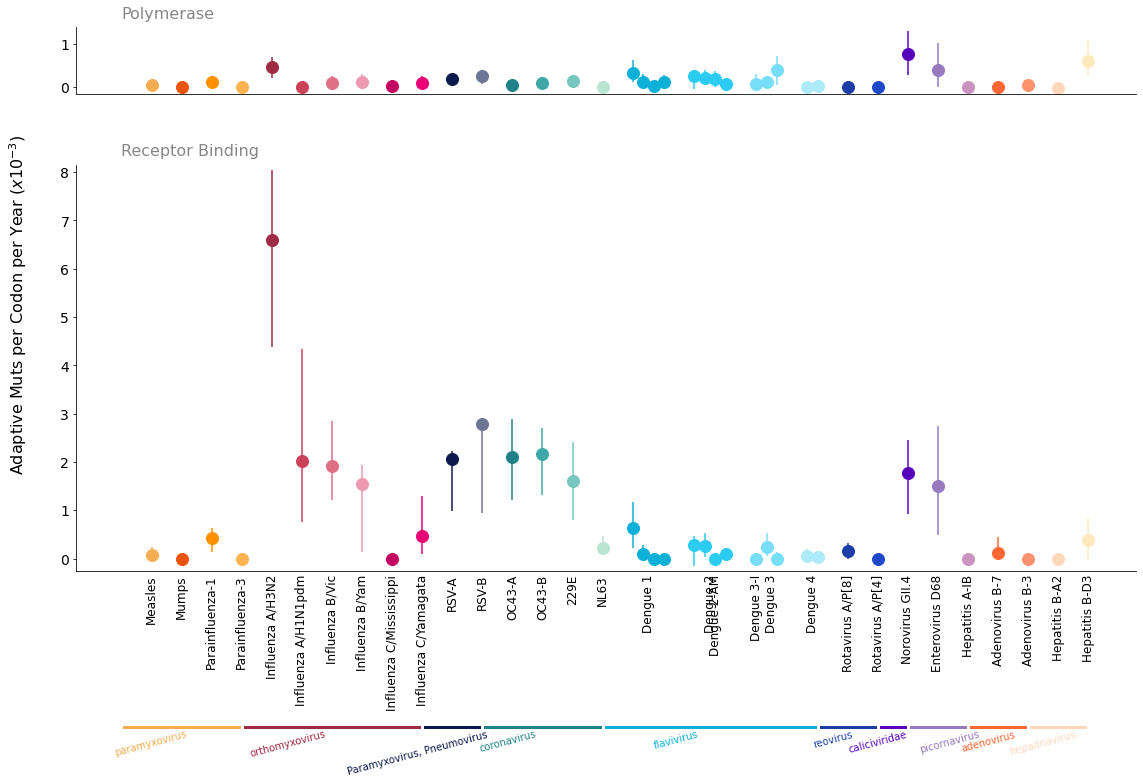

In [47]:
compare_viruses_adaptive_rate(['measles', 'mumps', 'parainfluenza', 'h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC', 
                               'rsv', 'oc43', '229e', 'nl63', 'dengue', 
                               'rotavirusAg1p8', 'rotavirusAg1p4', 'norovirus', 'enterovirusd68', 
                               'hepatitisA_IB', 'adenovirusB7', 'adenovirusB3', 'hepatitisB'], 
                              standard_genes=['polymerase', 'receptor_binding'], 
                                  exclude=None,
                                  window=5, min_seqs=3, bootstrap=True, update_outgroup=True,
                                  midfreq_high=0.75, midfreq_low=0.15, year_max=None, year_min=None, filename=None)

In [57]:
compare_viruses_adaptive_rate(['parvovirusB19'], 
                              standard_genes=['polymerase', 'receptor_binding'], 
                                  exclude=None,
                                  window=5, min_seqs=3, bootstrap=True, update_outgroup=True,
                                  midfreq_high=0.75, midfreq_low=0.15, year_max=None, year_min=None, filename=None)

KeyError: 'NS'

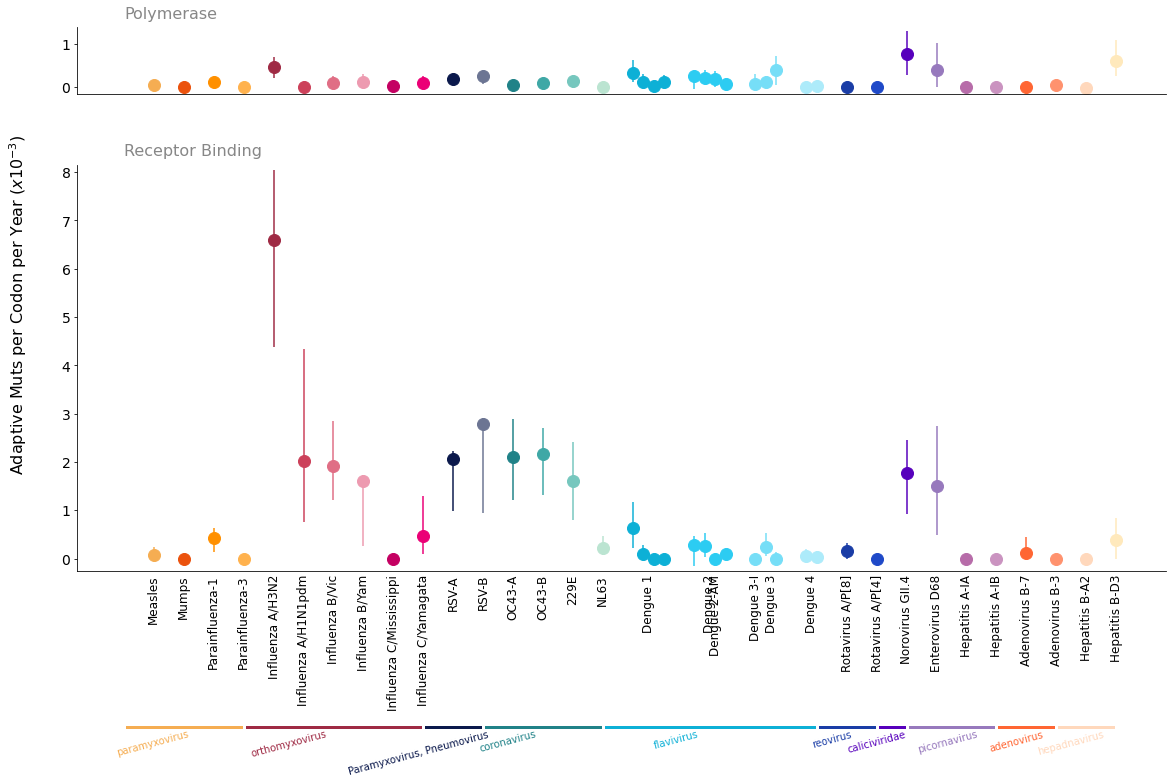

In [73]:
compare_viruses_adaptive_rate(['measles', 'mumps', 'parainfluenza', 'h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC', 
                               'rsv', 'oc43', '229e', 'nl63', 'dengue', 
                               'rotavirusAg1p8', 'rotavirusAg1p4', 'norovirus', 'enterovirusd68', 
                               'hepatitisA_IA', 'hepatitisA_IB', 
                               'adenovirusB7', 'adenovirusB3', 'hepatitisB'], 
                              standard_genes=['polymerase', 'receptor_binding'], 
                                  exclude=None,
                                  window=5, min_seqs=3, bootstrap=True, update_outgroup=True,
                                  midfreq_high=0.75, midfreq_low=0.15, year_max=None, year_min=None, filename=None)